In [1]:
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
import os
import shutil
import json
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import layers
from keras import optimizers
from keras import metrics
from keras.callbacks import ModelCheckpoint

2023-12-22 19:37:14.173464: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 19:37:14.198285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 19:37:14.580706: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# data = pd.read_csv("lsa64_dataset_best_80_fps_augmented.csv")

In [4]:
frames = 30

In [5]:
data = pd.read_csv(f"datasets/libras_minds_dataset_openpose_augmented.csv")

In [6]:
# data = pd.read_csv(f"datasets/lsa64_dataset_openpose_{frames}_frames_augmented.csv")

In [7]:
# data = pd.read_csv(f"datasets/lsa64_dataset_openpose_120_frames_augmented.csv")

In [8]:
# data = pd.read_csv(f"datasets/lsa64_dataset_openpose_40_frames_augmented_3.csv")

In [9]:
data.category.unique()

array(['hello', 'howAre', 'love', 'mask', 'no', 'please', 'sorry',
       'thanks', 'wear', 'you'], dtype=object)

In [10]:
def reshape_features_dataset(features):
    return features.reshape((int(features.shape[0]/frames), frames, features.shape[1]))

def reshape_target_dataset(target):
    return target.reshape((int(target.shape[0]/frames), frames))[:, 0]

In [11]:
data.columns

Index(['Unnamed: 0', 'category', 'video_name', 'frame', 'hand_0_0_x',
       'hand_0_0_y', 'hand_0_0_z', 'hand_0_1_x', 'hand_0_1_y', 'hand_0_1_z',
       ...
       'pose_22_z', 'pose_23_x', 'pose_23_y', 'pose_23_z', 'pose_24_x',
       'pose_24_y', 'pose_24_z', 'missing_hand', 'missing_face', 'person'],
      dtype='object', length=418)

In [12]:
hand_columns = [i for i in list(data.columns) if i.startswith("hand_")]
hand_0_columns_x = [i for i in list(data.columns) if i.startswith("hand_0_") and i.endswith("_x")]
hand_0_columns_y = [i for i in list(data.columns) if i.startswith("hand_0_") and i.endswith("_y")]
hand_1_columns_x = [i for i in list(data.columns) if i.startswith("hand_1_") and i.endswith("_x")]
hand_1_columns_y = [i for i in list(data.columns) if i.startswith("hand_1_") and i.endswith("_y")]
len(hand_columns) / 3

42.0

In [13]:
pose_columns = [i for i in list(data.columns) if i.startswith("pose_")]
pose_columns_x = [i for i in list(data.columns) if i.startswith("pose_") and i.endswith("_x")]
pose_columns_y = [i for i in list(data.columns) if i.startswith("pose_") and i.endswith("_y")]
len(pose_columns) / 3

25.0

In [14]:
face_columns = [i for i in list(data.columns) if i.startswith("face_")]
face_columns_x = [i for i in list(data.columns) if i.startswith("face_") and i.endswith("_x")]
face_columns_y = [i for i in list(data.columns) if i.startswith("face_") and i.endswith("_y")]
len(face_columns) / 3

70.0

In [15]:
(126+75+210)/3

137.0

In [16]:
def normalize_hand_columns(df):
    for i in hand_0_columns_x:
        df[i] -= df["hand_0_2_x"]
    for i in hand_0_columns_y:
        df[i] -= df["hand_0_2_y"]
    for i in hand_1_columns_x:
        df[i] -= df["hand_1_2_x"]
    for i in hand_1_columns_y:
        df[i] -= df["hand_1_2_y"]
#     df[hand_0_columns_x] -= df["hand_0_2_x"]
#     df[hand_0_columns_y] -= df["hand_0_2_y"]
#     df[hand_1_columns_x] -= df["hand_1_2_x"]
#     df[hand_1_columns_y] -= df["hand_1_2_y"]
    return df
    
def normalize_pose_columns(df):
    for i in pose_columns_x:
        df[i] -= df["pose_0_x"]
    for i in pose_columns_y:
        df[i] -= df["pose_0_y"]
#     df[pose_columns_x] -= df["pose_0_x"]
#     df[pose_columns_y] -= df["pose_0_y"]
    return df

def normalize_face_columns(df):
    for i in face_columns_x:
        df[i] -= df["face_30_x"]
    for i in face_columns_y:
        df[i] -= df["face_30_y"]
#     df[face_columns_x] -= df["face_30_x"]
#     df[face_columns_y] -= df["face_30_y"]
    return df

In [17]:
z_columns = [i for i in list(data.columns) if i.endswith("_z")]

In [18]:
unnamed_columns = [i for i in list(data.columns) if i.startswith("Unnamed")]

In [19]:
excluded_body_landmarks = [10, 11, 13, 14, 19, 20, 21, 22, 23, 24]
excluded_body_landmarks = tuple([f"pose_{i}" for i in excluded_body_landmarks])
unwanted_pose_columns = [i for i in list(data.columns) if i.startswith(excluded_body_landmarks)]

In [20]:
categories = list(data["category"].unique())

In [21]:
data["category_index"] = data["category"].apply(lambda i: categories.index(i))

In [22]:
columns_to_drop = ["category", "category_index", "video_name", "frame", "missing_hand", "missing_face"] + z_columns + unnamed_columns
# columns_to_drop = ["Unnamed: 0", "Unnamed: 0.1", "category", "category_index", "video_name", "frame"]
predict_columns = "category_index"

In [23]:
data = normalize_hand_columns(data)
data = normalize_pose_columns(data)
data = normalize_face_columns(data)

In [24]:
# LOPO
num_validation = 1
num_test = 1
if "person" not in data.columns:
    data["person"] = data["video_name"].apply(lambda i: i.split("_")[1])
people = data["person"].unique()
validate_people = people[-num_validation:]
test_people = people[-(num_validation + num_test):-num_validation]
train_people = people[:-(num_validation + num_test)]

train_dataset = data[data["person"].isin(train_people)]
test_dataset = data[data["person"].isin(test_people)]
validate_dataset = data[data["person"].isin(validate_people)]

# Removing data augmentation for test and validation
test_dataset = test_dataset[(~test_dataset["video_name"].str.contains("augmented"))]
validate_dataset = validate_dataset[(~validate_dataset["video_name"].str.contains("augmented"))]

train_features = train_dataset.drop(columns_to_drop + ["person"], axis=1).values
df_mean = train_features.mean()
df_std = train_features.std()
train_features = (train_features - df_mean) / df_std
train_features = reshape_features_dataset(train_features)
train_target = train_dataset[predict_columns].values
train_target = reshape_target_dataset(train_target)

test_features = test_dataset.drop(columns_to_drop + ["person"], axis=1).values
test_features = (test_features - df_mean) / df_std
test_features = reshape_features_dataset(test_features)
test_target = test_dataset[predict_columns].values
test_target = reshape_target_dataset(test_target)

validate_features = validate_dataset.drop(columns_to_drop + ["person"], axis=1).values
validate_features = (validate_features - df_mean) / df_std
validate_features = reshape_features_dataset(validate_features)
validate_target = validate_dataset[predict_columns].values
validate_target = reshape_target_dataset(validate_target)

In [25]:
train_dataset

,Unnamed: 0,category,video_name,frame,hand_0_0_x,hand_0_0_y,hand_0_0_z,hand_0_1_x,hand_0_1_y,hand_0_1_z,...,pose_23_x,pose_23_y,pose_23_z,pose_24_x,pose_24_y,pose_24_z,missing_hand,missing_face,person,category_index
0,0,hello,hello_0.avi,0,0.027167,-0.077728,0.025427,0.025469,-0.073200,0.018061,...,0.000000,0.00000,0.0,0.000000,0.00000,0.0,False,False,0,0
1,1,hello,hello_0.avi,1,0.014783,-0.032599,0.124683,0.036389,-0.013646,0.042268,...,0.000000,0.00000,0.0,0.000000,0.00000,0.0,False,False,0,0
2,2,hello,hello_0.avi,2,0.003860,0.039458,0.017858,-0.028950,0.057471,0.018611,...,0.000000,0.00000,0.0,0.000000,0.00000,0.0,False,False,0,0
3,3,hello,hello_0.avi,3,0.000000,0.102749,0.033277,0.000653,-0.018286,0.028435,...,0.000000,0.00000,0.0,0.000000,0.00000,0.0,False,False,0,0
4,4,hello,hello_0.avi,4,0.068675,0.061332,0.055209,0.068027,0.034553,0.019473,...,0.000000,0.00000,0.0,0.000000,0.00000,0.0,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58495,20755,you,augmented3-you_23.avi,25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.092772,-0.06786,0.0,0.092772,-0.06786,0.0,False,False,1,9
58496,20756,you,augmented3-you_23.avi,26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.092772,-0.06786,0.0,0.092772,-0.06786,0.0,False,False,1,9
58497,20757,you,augmented3-you_23.avi,27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.092772,-0.06786,0.0,0.092772,-0.06786,0.0,False,False,1,9
58498,20758,you,augmented3-you_23.avi,28,0.019851,0.000817,0.030727,0.005267,-0.001619,0.021320,...,0.092772,-0.06786,0.0,0.092772,-0.06786,0.0,False,False,1,9


In [95]:
# Train test split
features = data.drop(columns_to_drop, axis=1).values
target = data[predict_columns].values

features = reshape_features_dataset(features)
target = reshape_target_dataset(target)

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2)

df_mean = train_features.mean()
df_std = train_features.std()

train_features = (train_features - df_mean) / df_std
test_features = (test_features - df_mean) / df_std

In [26]:
train_features.mean()

-2.091977391546298e-15

In [27]:
train_features.std()

1.0000000000000009

In [28]:
train_features.shape

(1174, 30, 274)

In [29]:
validate_features.shape

(150, 30, 274)

In [30]:
test_target.shape

(150,)

(array([15., 15., 15., 15., 15., 15., 15., 15., 15., 15.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

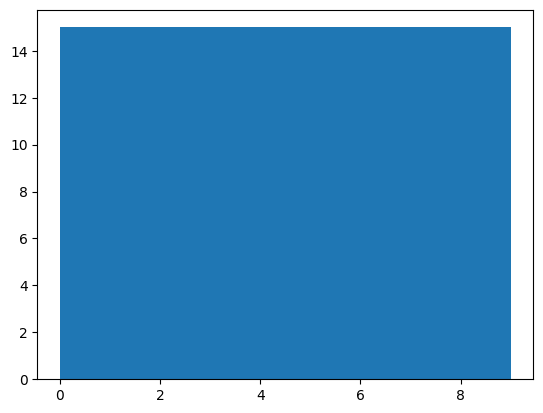

In [31]:
plt.hist(test_target)

In [32]:
from tensorflow import keras

In [33]:
1e-4 == 10e-5

True

In [34]:
10e-3

0.01

In [35]:
10e-4

0.001

In [ ]:
0.001

In [36]:
regulizer = keras.regularizers.L1(1e-4)

In [37]:
model = Sequential()
model.add(LSTM(
            32,
            input_shape=(frames, train_features.shape[2]),
            dropout=0.3, kernel_regularizer=regulizer, return_sequences=True)
         )
model.add(LSTM(32, dropout=0.3, kernel_regularizer=regulizer, return_sequences=True))
model.add(LSTM(32, dropout=0.3, kernel_regularizer=regulizer))
model.add(Dense(32, kernel_regularizer=regulizer))
model.add(Dropout(0.3))
model.add(Dense(32, kernel_regularizer=regulizer))
model.add(Dropout(0.3))
model.add(Dense(32, kernel_regularizer=regulizer))
model.add(Dense(10, activation='softmax'))

2023-12-22 19:38:00.025091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-22 19:38:00.135597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-22 19:38:00.135796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-22 19:38:00.138253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-22 19:38:00.138412: I tensorflow/compile

In [38]:
from keras import utils

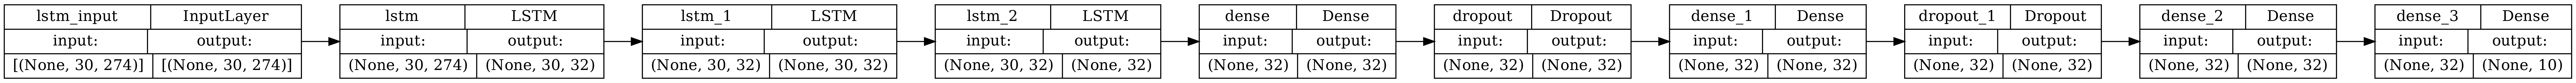

In [39]:
utils.plot_model(model, show_shapes=True, dpi=300, rankdir="LR")

In [40]:
# Diego's model params count: 161152
model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
print("\n".join(model_summary))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            39296     
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [41]:
model_name = "model_3_dense_dropout_035_l2_regulizers"
learning_rate = 10e-4
weight_decay = 10e-6
# learning_rate = 1e-5
# weight_decay = None
batch_size = 128
epochs = 200
best_model_file = ".best_model.hdf5"
output_folder = "model_results"

In [42]:
top_k_acc = metrics.TopKCategoricalAccuracy(
    k=5, name='top_k_categorical_accuracy', dtype=None
)

In [43]:
# Compile the model
optimizer = optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)
# optimizer = optimizers.Adam(learning_rate=1e-4)
# optimizer = optimizers.SGD(learning_rate=0.001)
mcp_save = ModelCheckpoint(best_model_file, save_best_only=True, monitor='val_accuracy', mode='max')
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'sparse_categorical_accuracy'])

In [44]:
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
if os.path.exists(best_model_file):
    os.remove(best_model_file)

In [45]:
# Train the model
result = model.fit(
    train_features,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validate_features, validate_target),
    callbacks=[mcp_save]
)

Epoch 1/200


2023-12-22 19:38:18.058085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-22 19:38:18.129006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-22 19:38:18.159507: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb3a57774a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-22 19:38:18.159536: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-12-22 19:38:18.186386: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-22 19:38:18.343314: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-12-22 19:38:18.411429: I ./t

10/10 [==============================] - 3s 79ms/step - loss: 2.6044 - accuracy: 0.1550 - sparse_categorical_accuracy: 0.1550 - val_loss: 2.4853 - val_accuracy: 0.2267 - val_sparse_categorical_accuracy: 0.2267
Epoch 2/200
 7/10 [====================>.........] - ETA: 0s - loss: 2.4283 - accuracy: 0.2411 - sparse_categorical_accuracy: 0.2411

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 24ms/step - loss: 2.4064 - accuracy: 0.2479 - sparse_categorical_accuracy: 0.2479 - val_loss: 2.3690 - val_accuracy: 0.2267 - val_sparse_categorical_accuracy: 0.2267
Epoch 3/200
10/10 [==============================] - 0s 16ms/step - loss: 2.2122 - accuracy: 0.2845 - sparse_categorical_accuracy: 0.2845 - val_loss: 2.0999 - val_accuracy: 0.3400 - val_sparse_categorical_accuracy: 0.3400
Epoch 4/200
10/10 [==============================] - 0s 17ms/step - loss: 2.0157 - accuracy: 0.3433 - sparse_categorical_accuracy: 0.3433 - val_loss: 1.9607 - val_accuracy: 0.4533 - val_sparse_categorical_accuracy: 0.4533
Epoch 5/200
10/10 [==============================] - 0s 13ms/step - loss: 1.7787 - accuracy: 0.3952 - sparse_categorical_accuracy: 0.3952 - val_loss: 1.8748 - val_accuracy: 0.3400 - val_sparse_categorical_accuracy: 0.3400
Epoch 6/200
10/10 [==============================] - 0s 17ms/step - loss: 1.6056 - accuracy: 0.4744 - sparse_categorical_acc

Epoch 39/200
10/10 [==============================] - 0s 14ms/step - loss: 0.5900 - accuracy: 0.8765 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.9940 - val_accuracy: 0.7467 - val_sparse_categorical_accuracy: 0.7467
Epoch 40/200
10/10 [==============================] - 0s 14ms/step - loss: 0.5480 - accuracy: 0.8901 - sparse_categorical_accuracy: 0.8901 - val_loss: 1.2564 - val_accuracy: 0.6933 - val_sparse_categorical_accuracy: 0.6933
Epoch 41/200
10/10 [==============================] - 0s 14ms/step - loss: 0.5668 - accuracy: 0.8927 - sparse_categorical_accuracy: 0.8927 - val_loss: 1.1372 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 42/200
10/10 [==============================] - 0s 14ms/step - loss: 0.5028 - accuracy: 0.9063 - sparse_categorical_accuracy: 0.9063 - val_loss: 1.0229 - val_accuracy: 0.7333 - val_sparse_categorical_accuracy: 0.7333
Epoch 43/200
10/10 [==============================] - 0s 14ms/step - loss: 0.5427 - accuracy: 0.8910 - spars

Epoch 76/200
10/10 [==============================] - 0s 13ms/step - loss: 0.4431 - accuracy: 0.9370 - sparse_categorical_accuracy: 0.9370 - val_loss: 1.6742 - val_accuracy: 0.7133 - val_sparse_categorical_accuracy: 0.7133
Epoch 77/200
10/10 [==============================] - 0s 14ms/step - loss: 0.4491 - accuracy: 0.9378 - sparse_categorical_accuracy: 0.9378 - val_loss: 1.5521 - val_accuracy: 0.6933 - val_sparse_categorical_accuracy: 0.6933
Epoch 78/200
10/10 [==============================] - 0s 14ms/step - loss: 0.4474 - accuracy: 0.9395 - sparse_categorical_accuracy: 0.9395 - val_loss: 1.6888 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 79/200
10/10 [==============================] - 0s 15ms/step - loss: 0.4220 - accuracy: 0.9378 - sparse_categorical_accuracy: 0.9378 - val_loss: 1.7173 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 80/200
10/10 [==============================] - 0s 13ms/step - loss: 0.4558 - accuracy: 0.9370 - spars

Epoch 113/200
10/10 [==============================] - 0s 14ms/step - loss: 0.4370 - accuracy: 0.9395 - sparse_categorical_accuracy: 0.9395 - val_loss: 1.7692 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 114/200
10/10 [==============================] - 0s 14ms/step - loss: 0.3837 - accuracy: 0.9523 - sparse_categorical_accuracy: 0.9523 - val_loss: 1.6968 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 115/200
10/10 [==============================] - 0s 14ms/step - loss: 0.3796 - accuracy: 0.9591 - sparse_categorical_accuracy: 0.9591 - val_loss: 1.8259 - val_accuracy: 0.7333 - val_sparse_categorical_accuracy: 0.7333
Epoch 116/200
10/10 [==============================] - 0s 13ms/step - loss: 0.3999 - accuracy: 0.9566 - sparse_categorical_accuracy: 0.9566 - val_loss: 2.1627 - val_accuracy: 0.6733 - val_sparse_categorical_accuracy: 0.6733
Epoch 117/200
10/10 [==============================] - 0s 13ms/step - loss: 0.4656 - accuracy: 0.9480 - 

Epoch 186/200
10/10 [==============================] - 0s 14ms/step - loss: 0.2880 - accuracy: 0.9821 - sparse_categorical_accuracy: 0.9821 - val_loss: 1.7258 - val_accuracy: 0.7533 - val_sparse_categorical_accuracy: 0.7533
Epoch 187/200
10/10 [==============================] - 0s 14ms/step - loss: 0.2915 - accuracy: 0.9761 - sparse_categorical_accuracy: 0.9761 - val_loss: 2.0419 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 188/200
10/10 [==============================] - 0s 13ms/step - loss: 0.2976 - accuracy: 0.9761 - sparse_categorical_accuracy: 0.9761 - val_loss: 1.8636 - val_accuracy: 0.7333 - val_sparse_categorical_accuracy: 0.7333
Epoch 189/200
10/10 [==============================] - 0s 14ms/step - loss: 0.2836 - accuracy: 0.9813 - sparse_categorical_accuracy: 0.9813 - val_loss: 1.8545 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 190/200
10/10 [==============================] - 0s 13ms/step - loss: 0.2901 - accuracy: 0.9804 - 

In [46]:
model.load_weights(best_model_file)

In [47]:
# Evaluate the model
loss, accuracy, cat_accuracy = model.evaluate(test_features, test_target)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test Caregorial accuracy:', cat_accuracy)

5/5 [==============================] - 0s 12ms/step - loss: 0.7815 - accuracy: 0.8267 - sparse_categorical_accuracy: 0.8267
Test loss: 0.7814618945121765
Test accuracy: 0.8266666531562805
Test Caregorial accuracy: 0.8266666531562805


In [48]:
# Evaluate the model
val_loss, val_accuracy, val_accuracy = model.evaluate(validate_features, validate_target)
print('Val loss:', val_loss)
print('Val accuracy:', val_accuracy)
print('Val Caregorial accuracy:', val_accuracy)

5/5 [==============================] - 0s 11ms/step - loss: 0.9082 - accuracy: 0.7933 - sparse_categorical_accuracy: 0.7933
Val loss: 0.9081528782844543
Val accuracy: 0.7933333516120911
Val Caregorial accuracy: 0.7933333516120911


In [49]:
max_val_acc = max(result.history["val_accuracy"])
max_val_acc_index = result.history["val_accuracy"].index(max_val_acc)
print("Max val_accuracy:", max_val_acc)
print("Max val_accuracy epoch:", max_val_acc_index)

Max val_accuracy: 0.7933333516120911
Max val_accuracy epoch: 29


Text(34, 0.8, 'Max val_accuracy')

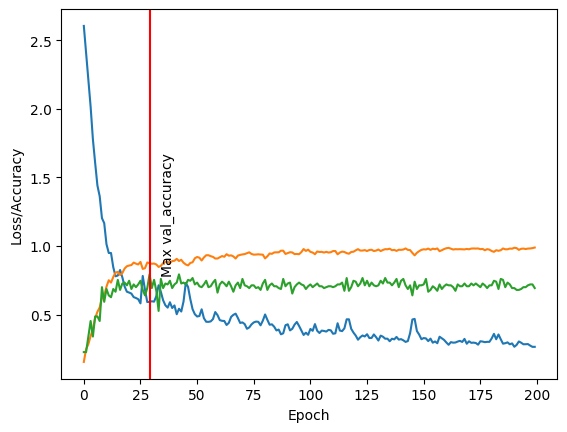

In [50]:
fig = plt.figure()
plt.plot(pd.DataFrame.from_dict(result.history)[["loss", "accuracy", "val_accuracy"]])
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.axvline(x=max_val_acc_index, color="red")
plt.text(max_val_acc_index + 5, 0.8, 'Max val_accuracy', rotation=90)

Text(34, 0.8, 'Max val_accuracy')

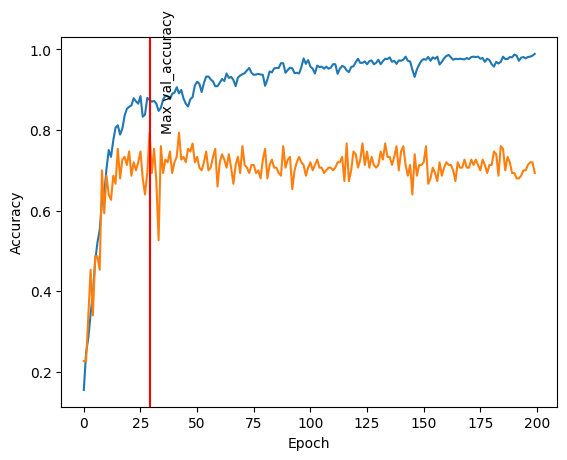

In [51]:
fig = plt.figure()
plt.plot(pd.DataFrame.from_dict(result.history)[["accuracy", "val_accuracy"]])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.axvline(x=max_val_acc_index, color="red")
plt.text(max_val_acc_index + 5, 0.8, 'Max val_accuracy', rotation=90)

In [184]:
model_description = {
    "name": model_name,
    "frames": frames,
    "dataset_augmented": True,
    "optimizer": {
        "name": "Adam",
        "learning_rate": learning_rate,
        "weight_decay": weight_decay
    },
    "epochs": epochs,
    "batch_size": batch_size,
    "total_params": model.count_params(),
    "test_loss": loss,
    "test_accuracy": accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    "max_val_accuracy_epoch": max_val_acc_index,
    "test_accuracy": accuracy,
    "history": result.history,
    "summary": "\n".join(model_summary),
}

In [185]:
# Save the model history
output_path = os.path.join(output_folder, model_description["name"])
file_name = "model_result.json"
fig_name = "graph.png"
if os.path.exists(output_path):
    raise Exception("Path already exists. Please choose another name")
os.makedirs(output_path)

shutil.copyfile(best_model_file, os.path.join(output_path, best_model_file))
fig.savefig(os.path.join(output_path, fig_name), dpi=300)

with open(os.path.join(output_path, file_name), "w") as f:
    json.dump(model_description, f)
    
print("Model result saved")

Model result saved


In [120]:
predictions = model.predict(test_features)
predictions_category_id = [i.argmax() for i in predictions]

5/5 [==============================] - 0s 12ms/step


In [121]:
def top_k_acc(predictions, correct, k):
    correct_value = predictions[correct]
    predictions.sort()
    return correct_value > predictions[-k]

In [122]:
top_5_acc = [top_k_acc(pred, cat, 5) for pred, cat in zip(predictions, test_target)]

In [123]:
df_predictions = pd.DataFrame.from_dict({"category": test_target, "prediction": predictions_category_id, "top_5_acc": top_5_acc})
df_predictions["correct"] = df_predictions["category"] == df_predictions["prediction"]
df_predictions

,category,prediction,top_5_acc,correct
0,0,0,True,True
1,0,4,True,False
2,0,4,True,False
3,0,4,True,False
4,0,4,True,False
...,...,...,...,...
145,9,9,True,True
146,9,9,True,True
147,9,9,True,True
148,9,9,True,True


In [124]:
len(df_predictions[df_predictions["top_5_acc"] == True]) / len(df_predictions)

0.9933333333333333

Text(0, 0.5, 'Prediction')

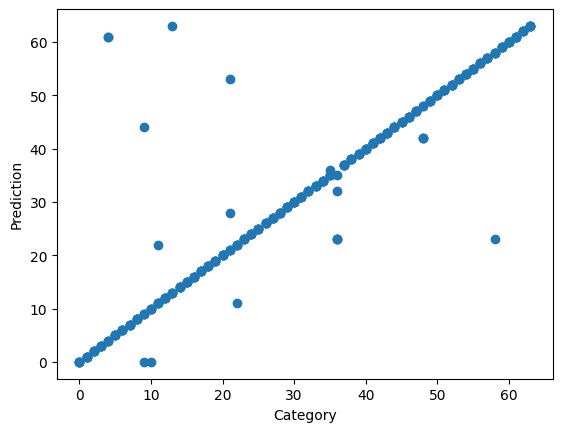

In [51]:
plt.scatter(x=df_predictions["category"], y=df_predictions["prediction"])
plt.xlabel("Category")
plt.ylabel("Prediction")

In [52]:
categories = df_predictions["category"].unique()
categories.sort()
for category in categories:
    df_category = df_predictions[df_predictions["category"] == category]
    correct = len(df_category[df_category["correct"] == True])
    count = len(df_category)
    print("Category:", category)
    print("Correct:", correct)
    print("Wrong:", count - correct)
    print("Precision:", correct/count * 100)
    print("="*16)
    print()

Category: 0
Correct: 5
Wrong: 0
Precision: 100.0

Category: 1
Correct: 5
Wrong: 0
Precision: 100.0

Category: 2
Correct: 5
Wrong: 0
Precision: 100.0

Category: 3
Correct: 5
Wrong: 0
Precision: 100.0

Category: 4
Correct: 3
Wrong: 2
Precision: 60.0

Category: 5
Correct: 5
Wrong: 0
Precision: 100.0

Category: 6
Correct: 5
Wrong: 0
Precision: 100.0

Category: 7
Correct: 5
Wrong: 0
Precision: 100.0

Category: 8
Correct: 5
Wrong: 0
Precision: 100.0

Category: 9
Correct: 3
Wrong: 2
Precision: 60.0

Category: 10
Correct: 4
Wrong: 1
Precision: 80.0

Category: 11
Correct: 4
Wrong: 1
Precision: 80.0

Category: 12
Correct: 5
Wrong: 0
Precision: 100.0

Category: 13
Correct: 4
Wrong: 1
Precision: 80.0

Category: 14
Correct: 5
Wrong: 0
Precision: 100.0

Category: 15
Correct: 5
Wrong: 0
Precision: 100.0

Category: 16
Correct: 5
Wrong: 0
Precision: 100.0

Category: 17
Correct: 5
Wrong: 0
Precision: 100.0

Category: 18
Correct: 5
Wrong: 0
Precision: 100.0

Category: 19
Correct: 5
Wrong: 0
Precision: 10

In [29]:
df_predictions[df_predictions["category"] == 0]

,category,prediction,correct
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True


In [50]:
df_predictions[df_predictions["correct"] == True]["category"].value_counts()

category
0     5
28    5
30    5
33    5
37    5
39    5
42    5
43    5
45    5
46    5
47    5
48    5
49    5
50    5
53    5
55    5
56    5
57    5
59    5
60    5
61    5
29    5
31    5
15    5
25    5
24    5
4     5
22    5
7     5
20    5
8     5
18    5
12    5
27    4
2     4
6     4
54    4
51    4
9     4
26    4
44    4
36    4
23    4
63    4
17    3
11    3
21    3
35    3
5     3
3     3
52    2
41    2
58    2
14    1
19    1
1     1
Name: count, dtype: int64

In [25]:
# Saving model
model.save("models/asl/model_80_dropout.keras")

In [22]:
# Validation
validation_data = pd.read_csv("validate_dataset.csv")

In [23]:
validation_data

,Unnamed: 0,category,video_name,frame,hand_0_wrist_x,hand_0_wrist_y,hand_0_wrist_z,hand_0_thumb_cmc_x,hand_0_thumb_cmc_y,hand_0_thumb_cmc_z,...,pose_right_heel_z,pose_left_heel_x,pose_left_heel_y,pose_left_heel_z,pose_right_foot_index_x,pose_right_foot_index_y,pose_right_foot_index_z,pose_left_foot_index_x,pose_left_foot_index_y,pose_left_foot_index_z
0,0,0,hello.mp4,0,0.778732,0.533119,1.618656e-07,0.760882,0.535324,-0.018034,...,0.395898,0.572077,0.911452,0.501065,0.719199,0.972017,0.119681,0.488783,0.955139,0.242829
1,1,0,hello.mp4,1,0.780349,0.531990,2.006781e-07,0.765526,0.535483,-0.019550,...,0.411669,0.572511,0.911294,0.488532,0.719056,0.971016,0.124615,0.489077,0.955218,0.222932
2,2,0,hello.mp4,2,0.789860,0.532102,1.953509e-07,0.769175,0.535249,-0.012909,...,0.398743,0.574021,0.911196,0.440281,0.718746,0.970221,0.106521,0.489621,0.955267,0.175936
3,3,0,hello.mp4,3,0.788924,0.532276,2.103518e-07,0.768380,0.534756,-0.015882,...,0.436644,0.574857,0.911146,0.453911,0.718660,0.969597,0.106942,0.489658,0.955268,0.162054
4,4,0,hello.mp4,4,0.349383,0.268837,4.599055e-10,0.370172,0.267407,-0.015195,...,0.501966,0.575456,0.910632,0.530033,0.716889,0.969052,0.172926,0.490454,0.955318,0.231649
5,5,0,hello.mp4,5,0.785580,0.531081,2.303617e-07,0.761963,0.533857,-0.015278,...,0.544538,0.575521,0.909889,0.595152,0.716690,0.969041,0.227990,0.491607,0.955701,0.317404
6,6,0,hello.mp4,6,0.441508,0.162445,1.070640e-07,0.467898,0.163019,-0.007401,...,0.521477,0.575575,0.909088,0.603336,0.715843,0.969006,0.203265,0.492571,0.955709,0.331097
7,7,0,hello.mp4,7,0.465447,0.166934,1.335545e-07,0.497158,0.169014,-0.003429,...,0.531344,0.575584,0.907475,0.638983,0.714891,0.969012,0.206211,0.493177,0.955663,0.364467
8,8,0,hello.mp4,8,0.471391,0.166036,1.390416e-07,0.500977,0.170404,-0.007057,...,0.523898,0.574160,0.907230,0.632156,0.714896,0.969352,0.198824,0.493277,0.955528,0.354292
9,9,0,hello.mp4,9,0.464834,0.160303,1.670441e-07,0.493160,0.164720,-0.007812,...,0.560217,0.573337,0.907003,0.647405,0.714541,0.969358,0.225727,0.493262,0.955509,0.362772


In [24]:
validation_data = validation_data.drop(["Unnamed: 0", "category", "video_name", "frame"], axis=1).values

In [45]:
validation_data = validation_data.reshape((int(validation_data.shape[0]/frames), frames, validation_data.shape[1]))

In [46]:
validation_data.shape

(1, 30, 1623)

In [47]:
result = model.predict(validation_data)

1/1 [==============================] - 0s 17ms/step


In [50]:
result.argmax()

3